# FIT5202 Assignment 2A : Building models to predict future eCommerce sales

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Usage of Spark SQL is discouraged, and your can only use pandas to format results. For plotting, different visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size not exceed 20MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is also acceptable.)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
# Configure Spark using SparkConf
spark_conf = (SparkConf()
    .setAppName("MOTH_Sales_Prediction_A2A")  
    .set("spark.files.maxPartitionBytes", "20MB")  
    .setMaster("local[*]")  
)
spark = SparkSession.builder \
    .config(conf=spark_conf) \
    .getOrCreate()

1.1.2 Write code to define the schemas for category, customer, product, clickstream and transaction datasets, following the data types suggested in the metadata file.

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType
from pyspark.sql.functions import when, count, col, month , first , isnan
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import year , current_date
from pyspark.sql import functions as F
import pandas as pd
category_schema = StructType([
    StructField("category_id", IntegerType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True),
])
customer_schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True), 
    StructField("device_type", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_version", StringType(), True),
    StructField("home_location_lat", DoubleType(), True),
    StructField("home_location_long", DoubleType(), True),
    StructField("home_location", StringType(), True),
    StructField("home_country", StringType(), True),
    StructField("first_join_date", TimestampType(), True), 
])
product_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),  
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", IntegerType(), True),
])

clickstream_schema = StructType([
    StructField("session_id", StringType(), True),  
    StructField("event_name", StringType(), True),
    StructField("event_time", StringType(), True),
    StructField("event_id", StringType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("event_metadata", StringType(), True),
])
transaction_schema = StructType([
    StructField("created_at", TimestampType(), True),
    StructField("customer_id", IntegerType(), True),
    StructField("booking_id", IntegerType(), True),
    StructField("session_id", StringType(), True),  
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", DoubleType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", DoubleType(), True),
    StructField("shipment_date_limit", TimestampType(), True),
    StructField("shipment_location_lat", DoubleType(), True),
    StructField("shipment_location_long", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
])


1.1.3 Using predefined schema, write code to load the csv files into separate dataframes. Print the schemas of all dataframes.

In [3]:
category_df = spark.read.option("header", "true").option("inferSchema", "true").csv("category.csv")
customer_df = spark.read.option("header", "true").option("inferSchema", "true").csv("customer.csv")
product_df = spark.read.option("header", "true").option("inferSchema", "true").csv("product.csv")
click_stream_df = spark.read.option("header", "true").option("inferSchema", "true").csv("click_stream.csv")
transaction_df = spark.read.option("header", "true").option("inferSchema", "true").csv("new_transactions.csv")

print("Category DataFrame :")
category_df = category_df.drop("#")
category_df.printSchema()

print("Customer DataFrame :")
customer_df = customer_df.drop("#")
customer_df.printSchema()

print("Product DataFrame :")
product_df = product_df.drop("#")
product_df.printSchema()

print("Click stream DataFrame :")
click_stream_df = click_stream_df.drop("#")
click_stream_df.printSchema()

print("Transaction DataFrame :")
transaction_df= transaction_df.drop("#")
transaction_df.printSchema()


Category DataFrame :
root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)

Customer DataFrame :
root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: double (nullable = true)
 |-- home_location_long: double (nullable = true)
 |-- home_location: string (nullable = true)
 |-- home_country: string (nullable = true)
 |-- first_join_date: date (nullable = true)

Product DataFrame :
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable 

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the clickstream dataset, there are 9 types of events:  
VIEW_PROMO, SCROLL, ADD_PROMO, VIEW_ITEM, CLICK, PURCHASE, ADD_TO_CART, HOMEPAGE, SEARCH  
We categorize them into 3 different categories:  
Category 1(high value actions - highly likely to purchase): ADD_PROMO, ADD_TO_CART  
Category 2(medium value actions - likely to purchase): VIEW_PROMO, VIEW_ITEM, SEARCH  
Category 3(low value actions - just browsing):  SCROLL, HOMEPAGE, CLICK  
Perform the following tasks base on the clickstream dataframe and create a new dataframe.  

1.2.1 For each unique session_id, count the number of actions in each category and create 3 columns(num_cat_highvalue, num_cat_midvalue, num_cat_lowvalue).

Counting number of actions in each category and adding features into feature dataframe.
high value actions shows- highly likely to purchase
medium value actions shows- likely to purchase
low value actions shows- just browsing


In [4]:
category_conditions = {
    "Category 1": (col("event_name").isin(["ADD_PROMO", "ADD_TO_CART"])),
    "Category 2": (col("event_name").isin(["VIEW_PROMO", "VIEW_ITEM", "SEARCH"])),
    "Category 3": (col("event_name").isin(["SCROLL", "HOMEPAGE", "CLICK"]))
}
feature_df  = click_stream_df.select("session_id", "event_name") \
    .groupBy("session_id") \
    .agg(
        count(when(category_conditions["Category 1"], True)).alias("num_cat_highvalue"),
        count(when(category_conditions["Category 2"], True)).alias("num_cat_midvalue"),
        count(when(category_conditions["Category 3"], True)).alias("num_cat_lowvalue")
    )
feature_df .show(5)

+--------------------+-----------------+----------------+----------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|
+--------------------+-----------------+----------------+----------------+
|2fdb7762-98d5-432...|                1|               2|               2|
|e7f689a1-28a0-4fe...|                1|               1|               3|
|2faff3e1-25cf-438...|                2|               6|              13|
|3f2d99e1-51ff-402...|                1|               0|               2|
|5386d3f4-98ea-448...|                2|               9|              18|
+--------------------+-----------------+----------------+----------------+
only showing top 5 rows



1.2.2. Create 2 columns with percentage ratio of high value action and low value actions. (i.e. high value ratio = (count of high value actions)/(total actions) * 100%)

In [5]:
feature_df  = feature_df .withColumn(
    "total_actions",
    col("num_cat_highvalue") + col("num_cat_midvalue") + col("num_cat_lowvalue")
)
feature_df  = feature_df .withColumn(
    "high_value_ratio",
    (col("num_cat_highvalue") / col("total_actions")) * 100
)
feature_df  = feature_df .withColumn(
    "low_value_ratio",
    (col("num_cat_lowvalue") / col("total_actions")) * 100
)
feature_df .show(5)
feature_df.count()

+--------------------+-----------------+----------------+----------------+-------------+-----------------+------------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions| high_value_ratio|   low_value_ratio|
+--------------------+-----------------+----------------+----------------+-------------+-----------------+------------------+
|2fdb7762-98d5-432...|                1|               2|               2|            5|             20.0|              40.0|
|e7f689a1-28a0-4fe...|                1|               1|               3|            5|             20.0|              60.0|
|2faff3e1-25cf-438...|                2|               6|              13|           21|9.523809523809524|61.904761904761905|
|3f2d99e1-51ff-402...|                1|               0|               2|            3|33.33333333333333| 66.66666666666666|
|5386d3f4-98ea-448...|                2|               9|              18|           29|6.896551724137931| 62.06896551

895203

1.2.3 Create a new column “is_promotion” with value of 1 or 0 and add to feature_df. If there are “ADD_PROMO” actions in a session, set it to 1, otherwise 0.

Grouping click_stream_df by the "session_id" column and using pivot function to pivot the data by "event_name" column, 
The agg(count("*")) function count the number of times each event occur in each session.Selecting two columns from the DataFrame: "session_id" and "ADD_PROMO" creating a new dataframe and then joining this to feature dataframe on session id.

In [6]:
event_df = click_stream_df.groupBy("session_id").pivot("event_name").agg(count("*"))
event_df =event_df.fillna(0)
event_df=event_df.select("session_id","ADD_PROMO")
event_df = event_df.withColumnRenamed("ADD_PROMO", "is_promotion")
feature_df = feature_df.join(
    event_df,
    on="session_id",
    how="inner"
)
feature_df.show(5)
feature_df.count()

+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|
+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+
|00005746-17ec-449...|                1|              20|              44|           65|1.5384615384615385|  67.6923076923077|           0|
|0000a729-3de3-461...|                2|               0|               2|            4|              50.0|              50.0|           0|
|000128d0-c51c-411...|                2|               6|               6|           14|14.285714285714285|42.857142857142854|           0|
|000130b9-07d1-437...|                1|              11|              34|           46|2.1739130434782608| 73.91304347826086|           0|
|0001434a-955b-41a..

895203

1.2.4 For each unique session_id, base on event_time, extract the season. (note: The dataset is from Indonesia, Spring: Mar-May, Summer: Jun-Aug, Autumn: Sep-Nov, Winter: Dec-Feb)

Assuming if month is between March and May (3-5), the "season" is set to "Spring."
-June and August (6-8), the "season" is set to "Summer."
-September and November (9-11), the "season" is set to "Autumn."
-December, January, or February (12, 1, 2), the "season" is set to "Winter."
 & If none of the conditions are met then "Unknown."
Then creating a new DataFrame season_min_df by selecting the "session_id" and "season" and grouping  by "session_id,"
for unique sessions.Calculates the minimum (earliest) season value within that session.
and finally joining to feature dataframe

In [7]:
season_conditions = {
    "Spring": (month(col("event_time")).between(3, 5)),
    "Summer": (month(col("event_time")).between(6, 8)),
    "Autumn": (month(col("event_time")).between(9, 11)),
    "Winter": (month(col("event_time")).isin([12, 1, 2])),
}
click_stream_df = click_stream_df.withColumn(
    "season",
    when(season_conditions["Spring"], "Spring")
    .when(season_conditions["Summer"], "Summer")
    .when(season_conditions["Autumn"], "Autumn")
    .when(season_conditions["Winter"], "Winter")
    .otherwise("Unknown")
)
season_min_df = click_stream_df.select("session_id", "season") \
    .groupBy("session_id") \
    .agg(F.min("season").alias("min_season"))
season_min_df.show()
season_min_df.count()

+--------------------+----------+
|          session_id|min_season|
+--------------------+----------+
|00005746-17ec-449...|    Spring|
|0000a729-3de3-461...|    Spring|
|000128d0-c51c-411...|    Spring|
|000130b9-07d1-437...|    Autumn|
|0001434a-955b-41a...|    Autumn|
|0001971f-84ae-4ba...|    Summer|
|0001972b-927b-40a...|    Summer|
|0001d650-1218-4e8...|    Spring|
|0002451c-6217-4d0...|    Spring|
|0002b514-75f2-457...|    Summer|
|0002d4fd-9985-4fd...|    Spring|
|00034035-1258-409...|    Autumn|
|00037246-503b-4b5...|    Spring|
|0003cf84-4bba-4d7...|    Winter|
|0003ff81-e79d-4d8...|    Spring|
|00049358-f228-48a...|    Winter|
|0004a700-7db4-412...|    Summer|
|00052a85-d4c3-436...|    Autumn|
|000564d1-2ed4-464...|    Spring|
|00058dfc-08c3-45d...|    Summer|
+--------------------+----------+
only showing top 20 rows



895203

In [8]:
feature_df = feature_df.join(
    season_min_df,
    on="session_id",
    how="inner"
)
feature_df.show(5)
feature_df.count()

+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+----------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|min_season|
+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+----------+
|0000a729-3de3-461...|                2|               0|               2|            4|              50.0|              50.0|           0|    Spring|
|000128d0-c51c-411...|                2|               6|               6|           14|14.285714285714285|42.857142857142854|           0|    Spring|
|000130b9-07d1-437...|                1|              11|              34|           46|2.1739130434782608| 73.91304347826086|           0|    Autumn|
|0001434a-955b-41a...|                2|               1|               2|            5|      

895203

1.2.5 Join tables to find customer information and add columns to feature_df: gender, age, device type, home_location, first join year. (note: For some column, you need to perform transformation. For age, keep integer only.)

selecting some columns from customer dataframe to generate new_customer_df and joining it to new_customer_session_df to add extra column session id in new_customer_df. Then finally joining this dataframe to feature dataframe which will add gender, age, device type, home_location, first join year these new columns in featuredf.

In [9]:
new_customer_df = customer_df.select(
    "customer_id",
    "gender",
    "device_type",
    "home_location",
    year("first_join_date").alias("first_join_year"),
    (year(current_date()) - year("birthdate")).alias("age")
)
new_customer_session_df = transaction_df.select(
    "customer_id",
    "session_id"
)
joined_df = new_customer_df.join(new_customer_session_df, on="customer_id", how="left")
joined_df.show()

+-----------+------+-----------+-----------------+---------------+---+--------------------+
|customer_id|gender|device_type|    home_location|first_join_year|age|          session_id|
+-----------+------+-----------+-----------------+---------------+---+--------------------+
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|8fa2e44f-6869-43c...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|37957597-fd21-4f0...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|f2914d84-6bc3-4fd...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|6a893e64-9cb6-477...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|daf03fed-6257-459...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|273e235f-af99-4fc...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|2a41d2cf-8354-482...|
|       4766|     M|    Android|      Jawa Tengah|           2021| 30|f557b78e-1

In [10]:
feature_df = feature_df.join(joined_df, "session_id", "left")
feature_df.show()
feature_df.count()

+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+----------+-----------+------+-----------+-------------------+---------------+----+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|min_season|customer_id|gender|device_type|      home_location|first_join_year| age|
+--------------------+-----------------+----------------+----------------+-------------+------------------+------------------+------------+----------+-----------+------+-----------+-------------------+---------------+----+
|0000a729-3de3-461...|                2|               0|               2|            4|              50.0|              50.0|           0|    Spring|       2607|     M|    Android|       Jakarta Raya|           2021|  18|
|000128d0-c51c-411...|                2|               6|               6|           14|14.285714285714285|4

895203

1.2.6 Join tables to find out if the customer made purchase or not, and add to feature_df as 1 or 0. We will use this column as training label later.

Adding a new column made_purchase to feature_df which will store only 1 payment_status is Success or 0 if Fail

In [11]:
df = transaction_df.select(
    "session_id",
    "payment_status"
)
feature_df = feature_df.join(df, "session_id", "left")
feature_df = feature_df.withColumn(
    "made_purchase",
    when(feature_df["payment_status"] == "Success", 1).otherwise(0)
)
feature_df.show()
feature_df.count()

+--------------------+-----------------+----------------+----------------+-------------+------------------+-----------------+------------+----------+-----------+------+-----------+-------------------+---------------+----+--------------+-------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|  high_value_ratio|  low_value_ratio|is_promotion|min_season|customer_id|gender|device_type|      home_location|first_join_year| age|payment_status|made_purchase|
+--------------------+-----------------+----------------+----------------+-------------+------------------+-----------------+------------+----------+-----------+------+-----------+-------------------+---------------+----+--------------+-------------+
|0000a729-3de3-461...|                2|               0|               2|            4|              50.0|             50.0|           0|    Spring|       2607|     M|    Android|       Jakarta Raya|           2021|  18|          Fail|           

895203

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b)For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count.**

In [12]:
#dropping null values from feature_df
feature_df = feature_df.na.drop()
column_data_types =feature_df.dtypes
print("Datatypes :")
for column, data_type in column_data_types:
    print(f"Column '{column}' has data type '{data_type}'")

Datatypes :
Column 'session_id' has data type 'string'
Column 'num_cat_highvalue' has data type 'bigint'
Column 'num_cat_midvalue' has data type 'bigint'
Column 'num_cat_lowvalue' has data type 'bigint'
Column 'total_actions' has data type 'bigint'
Column 'high_value_ratio' has data type 'double'
Column 'low_value_ratio' has data type 'double'
Column 'is_promotion' has data type 'bigint'
Column 'min_season' has data type 'string'
Column 'customer_id' has data type 'int'
Column 'gender' has data type 'string'
Column 'device_type' has data type 'string'
Column 'home_location' has data type 'string'
Column 'first_join_year' has data type 'int'
Column 'age' has data type 'int'
Column 'payment_status' has data type 'string'
Column 'made_purchase' has data type 'int'


In [13]:
#Summary for numerical columns
c_numerical=['customer_id','num_cat_highvalue','num_cat_midvalue','num_cat_lowvalue','total_actions','high_value_ratio','low_value_ratio','first_join_year','age']
c_numerical = feature_df[c_numerical]
c_numerical.summary().show(10)


+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|       customer_id| num_cat_highvalue|  num_cat_midvalue| num_cat_lowvalue|     total_actions|  high_value_ratio|   low_value_ratio|   first_join_year|               age|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            852582|            852582|            852582|           852582|            852582|            852582|            852582|            852582|            852582|
|   mean|49839.197542289185|2.6051054326739247|3.4767916751702477|7.536056355869582|13.617953463713754| 26.83715888270127|51.904517056566206| 2018.674827758503|27.397053890417578|
| stddev|28999.357992518857| 2.301966945215055|4.5177145089369874|9.364566759935958|13.7711371559078

In [14]:
#for non numeric columns
c_categorical=['session_id','min_season','gender','device_type','home_location']
df2=feature_df[c_categorical]
for column in c_categorical:
    print(f"Column: {column}")
    df2.groupBy(column).count().orderBy(col("count").desc()).show(5, truncate=False)
    print("\n")

Column: session_id
+------------------------------------+-----+
|session_id                          |count|
+------------------------------------+-----+
|0000da55-698f-4d22-8b44-3ca192f2f961|1    |
|00001f29-3ede-4445-95f0-0178934e32ba|1    |
|00003eca-954b-4150-aee1-63fc62f395cf|1    |
|0000425b-ddc8-4459-a240-6ba814dac132|1    |
|00007415-e0e7-4a33-95e8-5bc749016876|1    |
+------------------------------------+-----+
only showing top 5 rows



Column: min_season
+----------+------+
|min_season|count |
+----------+------+
|Spring    |257174|
|Autumn    |215796|
|Summer    |197065|
|Winter    |182547|
+----------+------+



Column: gender
+------+------+
|gender|count |
+------+------+
|F     |543509|
|M     |309073|
+------+------+



Column: device_type
+-----------+------+
|device_type|count |
+-----------+------+
|Android    |656809|
|iOS        |195773|
+-----------+------+



Column: home_location
+-------------+------+
|home_location|count |
+-------------+------+
|Jakarta Raya

In [15]:
#value and count for boolean
c_boolean = ['made_purchase', 'is_promotion']
df3=feature_df[c_boolean]
boolean_df = df3.select(*c_boolean)
for column in c_boolean:
    result = boolean_df.groupBy(column).count()
    result.show()

+-------------+------+
|made_purchase| count|
+-------------+------+
|            1|527812|
|            0|324770|
+-------------+------+

+------------+------+
|is_promotion| count|
+------------+------+
|           0|526047|
|           1|326535|
+------------+------+



**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots.**
- One of the plots needs to base on feature_df, you’re free to choose the other one.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots; 2: if your data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  
- Please only use the provided data for visualisation  


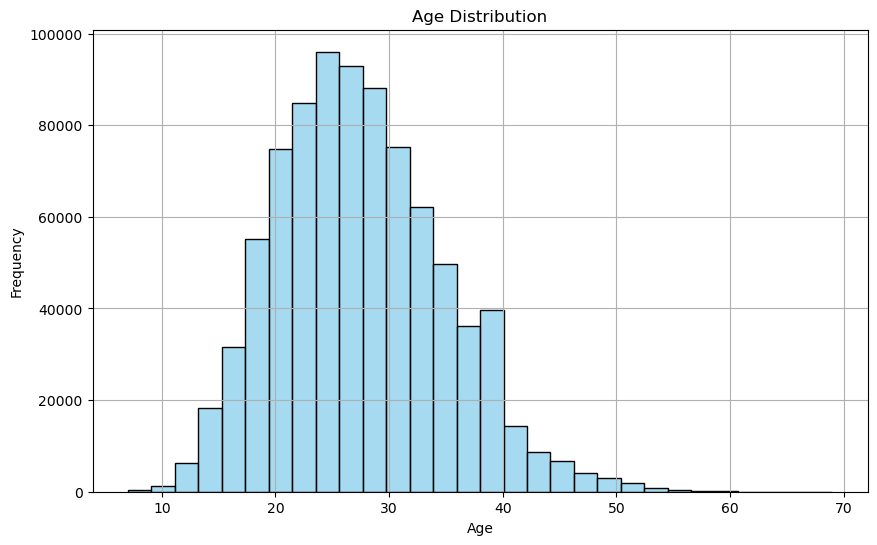

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

#Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=feature_df.toPandas(), x="age", bins=30, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Grouped bar plot that illustrates the relationship between "device_type" and "gender" & "made_purchase" label. 
Findings:

The x-axis represents different "device_type" categories.
The bars are grouped by "device_type," & further divided into two sections: "Male" and "Female" genders.
The height of each bar represents the count of occurrences for each category combination.

This plot helps visualize the distribution of purchase behavior among different device types and genders, it seems females who use Android device have higly puchased and males with ios had minimum.

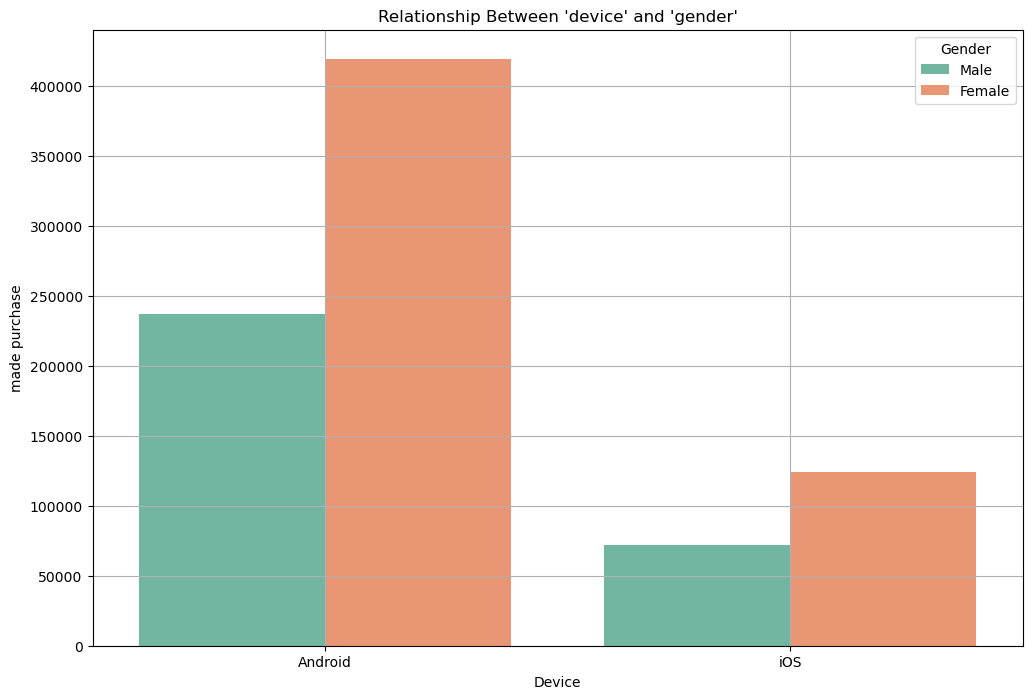

In [17]:
# Relationship Between "device," "gender," and "made_purchase"
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = feature_df.toPandas()
plt.figure(figsize=(12, 8))
sns.countplot(data=plot_df, x="device_type", hue="gender", palette="Set2", saturation=0.75)
plt.title("Relationship Between 'device' and 'gender'")
plt.xlabel("Device")
plt.ylabel("made purchase")
plt.legend(title="Gender", labels=["Male", "Female"])
plt.grid(True)
plt.show()


##Payment Status Distribution 
-Bar Chart
Visualizing the distribution of payment statuses among the customers in the dataset using a bar chart.
Description:
The bar chart displays the count of customers for each payment status category(success or fail). It provides insights into the success and failure rates of payments made by customers.
Findings:
The majority of customers have a payment status of "Success," indicating successful payments.
There is a smaller group with a payment status of "Failed," suggesting payment issues.
Understanding payment statuses can help the company identify areas where payment processes can be improved and where customer support may be needed.
It supports data-driven insights and decision-making, making it a valuable asset for the company's financial and customer service strategies.

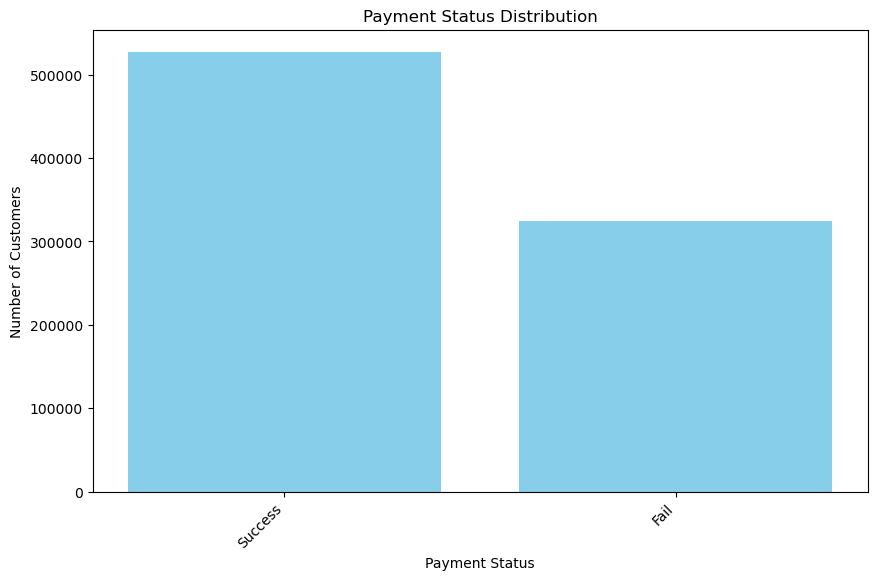

In [18]:
# Payment status Distribution
import matplotlib.pyplot as plt
feature_df = feature_df.fillna("Unknown", subset=["payment_status"])
payment_status_counts = feature_df.groupBy("payment_status").count().orderBy("count", ascending=False).toPandas()# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(payment_status_counts["payment_status"], payment_status_counts["count"], color='skyblue')
plt.title("Payment Status Distribution")
plt.xlabel("Payment Status")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45, ha="right")
plt.show()


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you will need to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the situation we have, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Please only use the provided data for model building
- You can create/add additional feature/column based on the dataset
- Hint - things to consider include whether to create more feature columns, whether to remove some columns, using the insights from the data exploration/domain knowledge/statistical models  

#Feature Importance:
Numeric Features: "num_cat_highvalue," "num_cat_midvalue," "num_cat_lowvalue", "high_value_ratio," and "low_value_ratio","age" are important. These features can provide insights into customer behavior, such as the distribution of actions, the ratio of high-value to low-value actions also "Age" is an essential feature, as it often correlates with purchase behavior. It's possible that different age groups have varying propensities to make purchases.These features have a significant impact on whether a customer makes a purchase(made_purchase).
high_value_ratio, low_value_ratio columns may represent ratios or proportions related to spending behavior, which can be valuable in predictive modeling.
first_join_year can provide insights into customer loyalty and behavior changes over time.


#Categorical Features:These features may capture customer preferences and location-specific behaviors, which can influence purchase decisions.("season," "gender," "device_type," and "home_location").
Gender is a common demographic feature that can influence purchasing decisions 
The type of device used by customers can impact their interaction with a platform or service, potentially affecting purchase behavior also customer location or region can play a role in purchase preferences and behavior.



#Feature Removal:
Session ID & Customer ID- The "session_id","customer_id" feature is likely not useful for predicting purchase behavior. And as customer_id it's likely to be unique for each customer it is not of much use. dropping total_action column too as we got high_value_ratio',low_value_ratio' from it which is more important.

2.1.2 Write code to create/transform the columns based on your discussion above
- Hint: You can use one dataframe for both two use cases(classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 


In [19]:
feature_df = feature_df.withColumnRenamed("min_season", "season")
columns_to_drop = ['session_id', 'total_actions','customer_id']
feature_df = feature_df.drop(*columns_to_drop)
numerical_cols = ['num_cat_highvalue', 'num_cat_lowvalue', 'num_cat_midvalue', 'high_value_ratio',
                    'low_value_ratio', 'first_join_year', 'age']
categorical_cols = ['season', 'gender', 'device_type', 'home_location', 'is_promotion']
label_column = 'made_purchase'
feature_df.printSchema()

root
 |-- num_cat_highvalue: long (nullable = false)
 |-- num_cat_midvalue: long (nullable = false)
 |-- num_cat_lowvalue: long (nullable = false)
 |-- high_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: long (nullable = true)
 |-- season: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- first_join_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- payment_status: string (nullable = false)
 |-- made_purchase: integer (nullable = false)



### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet**

In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
category_c = categorical_cols + [label_column]
indexer = StringIndexer(inputCols=category_c, outputCols=[f'{col}_index' for col in categorical_cols] + ['label'])
encoder = OneHotEncoder(inputCols=indexer.getOutputCols()[:-1], outputCols=[f'{col}_vec' for col in categorical_cols])
input_cols_assembler = encoder.getOutputCols() + numerical_cols  
assembler = VectorAssembler(inputCols=input_cols_assembler, outputCol='features')

rf = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=3)
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxDepth=3)


**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet**

In [21]:
from pyspark.ml import Pipeline

rf_pipeline = Pipeline(stages = [indexer, encoder, assembler,rf])
gbt_pipeline= Pipeline(stages = [indexer, encoder, assembler, gbt])


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.  
Note: Due to the large size of the dataset, you can choose to use random sampling (say 20% of the dataset) and do a train/test split; or use one year of data for training and another year for testing. 

In [22]:
sample = feature_df.sample(fraction=0.2, seed=143)
train_data, test_data = sample.randomSplit([0.8, 0.2], seed = 148)
print("Training Dataset Count: " + str(train_data.count ( )))
print("Test Dataset Count: " + str(test_data.count( )))

Training Dataset Count: 136426
Test Dataset Count: 34155


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [23]:
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)
gbt_model = gbt_pipeline.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
rf_predictions.select("made_purchase", "prediction", "probability").show(5)
gbt_predictions.select("made_purchase", "prediction", "probability").show(5)

+-------------+----------+--------------------+
|made_purchase|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.51812017222910...|
|            1|       0.0|[0.51249239053709...|
|            1|       0.0|[0.51249239053709...|
|            1|       0.0|[0.51249239053709...|
|            1|       0.0|[0.51249239053709...|
+-------------+----------+--------------------+
only showing top 5 rows

+-------------+----------+--------------------+
|made_purchase|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.59305935929195...|
|            1|       0.0|[0.59305935929195...|
|            1|       0.0|[0.59305935929195...|
|            1|       0.0|[0.59305935929195...|
|            1|       0.0|[0.59305935929195...|
+-------------+----------+--------------------+
only showing top 5 rows



2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
- Draw a ROC plot.
- Discuss which one is the better model(no word limit, please keep it concise)

In [24]:
TN = rf_predictions.filter('prediction = 0 AND label = 0').count()
TP = rf_predictions.filter('prediction = 1 AND label = 1').count()
FN = rf_predictions.filter('prediction = 0 AND label = 1').count()
FP = rf_predictions.filter('prediction = 1 AND label = 0').count()
rf_predictions.groupBy('label', 'prediction').count().show()
accuracy = (TP + TN)/(TP + TN + FN +FP)
precision = (TP )/(TP +FP)
recall = (TP )/(TP +FN)
f1 = (2/((1/recall) + (1/precision)))


print("Random Forest:")
print("True Negatives (TN):", TN)
print("True Positives (TP):", TP)
print("False Negatives (FN):",FN)
print("False Positives (FP):",FP)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5186|
|  0.0|       1.0|   87|
|  1.0|       0.0| 7775|
|  0.0|       0.0|21107|
+-----+----------+-----+

Random Forest:
True Negatives (TN): 21107
True Positives (TP): 5186
False Negatives (FN): 7775
False Positives (FP): 87
Accuracy: 0.7698140828575611
Precision: 0.9835008534041343
Recall: 0.40012344726487153
F1-Score: 0.5688274651749479


In [25]:

TN = gbt_predictions.filter('prediction = 0 AND made_purchase  = 0').count()
TP = gbt_predictions.filter('prediction = 1 AND made_purchase  = 1').count()
FN = gbt_predictions.filter('prediction = 0 AND made_purchase  = 1').count()
FP = gbt_predictions.filter('prediction = 1 AND made_purchase  = 0').count()
gbt_predictions.groupBy('made_purchase', 'prediction').count().show()
accuracy = TP+TN/TP+TN+FN+FP
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2  * (precision * recall) / (precision + recall)

print("True Negatives:", TN)
print("True Positives:", TP)
print("False Negatives:", FN)
print("False Positives:", FP)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


+-------------+----------+-----+
|made_purchase|prediction|count|
+-------------+----------+-----+
|            1|       0.0|21167|
|            0|       0.0| 6493|
|            1|       1.0|   27|
|            0|       1.0| 6468|
+-------------+----------+-----+

True Negatives: 6493
True Positives: 27
False Negatives: 21167
False Positives: 6468
Accuracy: 34395.48148148148
Precision: 0.004157043879907622
Recall: 0.001273945456261206
F1-Score: 0.0019502329444905917


Area Under ROC: 0.8463020157080585


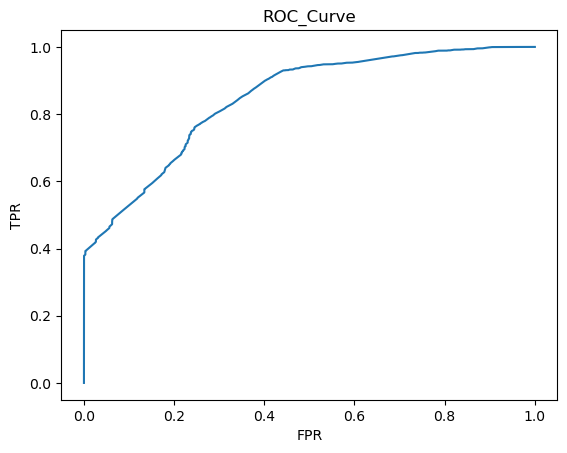

In [26]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Area Under ROC: " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))
roc_details = rf_model.stages[-1].summary
roc = roc_details.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC_Curve')
plt.show()

Area Under ROC: 0.8700260066936533


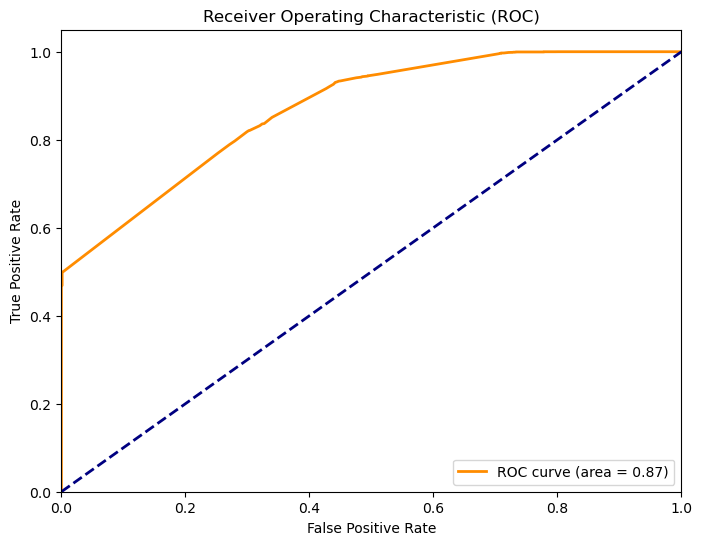

In [28]:
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = gbt_model.transform(test_data)  
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: " + str(auc))
prob_col = 'probability'  
label_col = 'label'  
probs = np.array(predictions.select(prob_col).rdd.map(lambda x: x[0][1]).collect())
labels = np.array(predictions.select(label_col).rdd.map(lambda x: x[0]).collect())
fpr, tpr, _ = roc_curve(labels, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


#(Receiver Operating Characteristic)ROC -----------------
#######
ROC curve is a graphical representation of a binary classification model's performance. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds. Essentially, it shows how well the model distinguishes between positive and negative classes as the threshold for classification changes.

#AUC- It represents the area under the ROC curve and ranges from 0 to 1. A higher AUC indicates better model performance. An AUC of 0.5 suggests that the model performs no better than random chance, while an AUC of 1 indicates perfect performance.
An AUC of 0.8463 for Random forest and 0.8702 for Gradient-boosted tree (GBT) model suggests that both models are performing reasonably well but  gbt has slightly better discriminatory power in distinguishing between positive and negative samples.However, the choice of the "better" model also depends on the specific requirements and goals of your application.

2.4.3 Save the better model, we will need this for Part B of assignment 2.  
(note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [29]:
#gbt_model.save("/Users/komalattrey/Bigdata/gbt_model")

### Part 3. Customer Segmentation and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

In [30]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
numerical_cols = ['num_cat_highvalue', 'num_cat_lowvalue', 'num_cat_midvalue', 'high_value_ratio',
                  'low_value_ratio', 'first_join_year', 'age']
categorical_cols = ['season', 'gender', 'device_type', 'home_location', 'is_promotion']

selected_features = numerical_cols + categorical_cols
selected_df =feature_df.select(*selected_features)
for col in categorical_cols:
    selected_df = selected_df.withColumn(col, selected_df[col].cast("string"))
    selected_df = selected_df.dropna(subset=[col])
    selected_df = selected_df.fillna({col: 'Unknown'})

    category_col = col + "_encoded"
    encoder = StringIndexer(inputCol=col, outputCol=category_col)
    model = encoder.fit(selected_df)
    selected_df = model.transform(selected_df)

assembler = VectorAssembler(inputCols=[col + "_encoded" if col in categorical_cols else col for col in selected_features],
                            outputCol="features")
data = assembler.transform(selected_df)


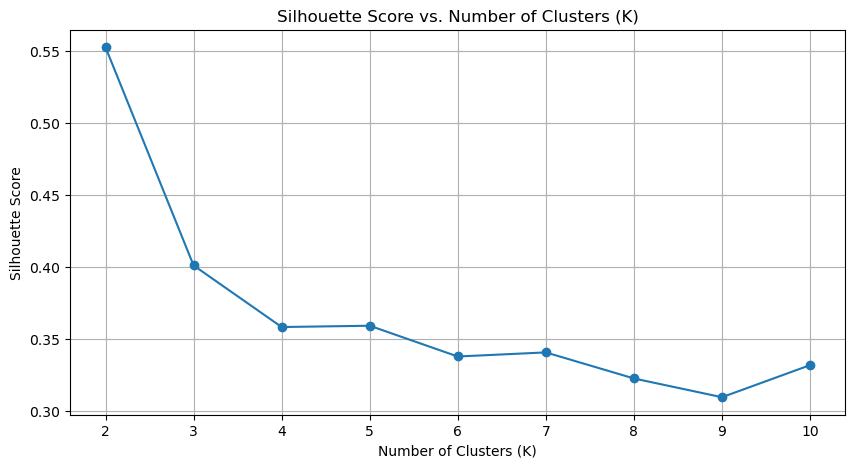

DataFrame[prediction: int]

In [31]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the Silhouette scores for different K values
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.grid(True)
plt.show()


optimal_k = k_values[np.argmax(silhouette_scores)]
kmeans = KMeans().setK(optimal_k).setSeed(1)
model = kmeans.fit(data)
assignments = model.transform(data)
assignments.select("prediction")



In [32]:
from pyspark.ml.evaluation import ClusteringEvaluator
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data)
assignments = model.transform(data)
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(assignments)
print(f"Silhouette Score for K=2: {silhouette_score}")


Silhouette Score for K=2: 0.5525549738075354


In [33]:
from pyspark.sql.functions import mean, col
cluster_0_data = assignments.filter(assignments["prediction"] == 0)
average_values = cluster_0_data.select([mean(col).alias(col) for col in numerical_cols])
average_values.show()


+------------------+------------------+----------------+----------------+------------------+------------------+------------------+
| num_cat_highvalue|  num_cat_lowvalue|num_cat_midvalue|high_value_ratio|   low_value_ratio|   first_join_year|               age|
+------------------+------------------+----------------+----------------+------------------+------------------+------------------+
|1.9454544097115938|10.087953457814145|4.40428577827882|16.9095677929387|61.103437273711734|2018.8161176769222|27.427527007757032|
+------------------+------------------+----------------+----------------+------------------+------------------+------------------+



#
K=2 was chosen because it yielded the highest Silhouette Score in the analysis, indicating that dividing the data into two clusters provided the best separation among the data points. 

#
Certainly! result shows Cluster 0 represents a unique customer segment characterized by younger customers with a preference for lower-value transactions but frequent.
Recommend -Tailoring marketing strategies and product offerings to resonate with their spending habits. Consider mobile-friendly experiences, as this group likely engages with us through digital channels.We can ensuring that our business effectively meets the needs and preferences of this specific customer segment.
Create marketing campaigns and product offerings that resonate with cost-conscious consumers.

#
Similarly another Cluster 1 represents a customer segment that might engage in high-value transactions and could have distinct demographic characteristics, or the age can vary. Tailoring strategies to meet the preferences of this group can lead to increased customer loyalty and revenue growth.
Personalized recommendations and promotions that align with the spending habits of this group.




### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

#
Data Ethics and Fairness:
Data ethics involves adhering to moral principles and guidelines during data collection, use, and dissemination. It emphasizes fairness, transparency, and accountability throughout the data lifecycle. It's essential to address biases and discrimination that may arise from biased data or algorithms.

-Fairness: Data scientists should aim for unbiased decision-making.
-Transparency: Ethical data practices promote openness and understanding, fostering trust among stakeholders.
-Consent: Companies must be transparent, request consent, and safeguard sensitive information.
#
Data Privacy:
-Data privacy is a legal requirement that protects individuals' personal information from unauthorized access, use, or disclosure. Big data poses unique challenges due to the vast volume of data collected and analyzed.

Challenges: Ensuring personally identifiable information remains un-traceable can be difficult with diverse datasets.
Consent and Transparency: Obtaining informed consent and transparent data collection and usage are essential challenges.
#
Data Security:
Data security involves safeguarding data from unauthorized access, alteration, or destruction.

Security Risks: Unauthorized access can lead to data breaches, causing reputational and financial damage.
Employee Actions: Malicious or negligent employee actions pose significant security risks.
Big Data Complexity: The complexity of big data makes robust security measures challenging to implement.

## References:
Please add your references below:

In [ ]:
http://127.0.0.1:8888/notebooks/Bigdata/Week6_Classification%20Algorithms.ipynb
http://127.0.0.1:8888/notebooks/Bigdata/FIT5202%20Week7_Part%20A%20-%20K-Means%20Clustering(Moodle).ipynb